# Assignment 2 : clustering neighbourhoods in Toronto

Import required packages

In [242]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt



## create BS object, list and create dictionary

In [243]:
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').read()

#create soup
soup = BeautifulSoup(source)

#create List
list_postalcode = [1,2,3]

#create dictionary called cell having 3 keys PostalCode, Borough, Neighbourhood
cell = {"PostalCode" :"","Borough" :"","Neighbourhood" : ""}

In [244]:
#create table
table_contents=[]
#create soup, get table
table=soup.find('table')
#create dict with 3 keys, extract data and append to table
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

#print(table_contents)
#create dataframe using list table_contents
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
#print(df.shape)
#print(type(df))


In [ ]:
#attempt to use geocoder, didnt work
import geocoder
g = geocoder.canadapost('M3A, Toronto, Ontario'.format(postal_code))
print(g.latlng)

In [245]:
import geocoder # import geocoder
import pgeocode #utilize pgecode instead

In [246]:
#this cell utilizes pgeocode to get lats and logs into lists of lats and longs
pgeocode.Nominatim('ca')
geolocator = pgeocode.Nominatim('ca')
postal_codes = df['PostalCode'].tolist()
latitudes = []
longitudes = []
for i, postal_code in enumerate(postal_codes):
    # initialize your variable to None
    #print(f'--Getting Postal Code: {postal_code}')
    g = geolocator.query_postal_code(postal_code)
    
    if not g.empty:
        #print(f'Postal Code {postal_code} has been retrieved. {len(postal_codes) - (i + 1)} codes left')
        latitudes.append(g.latitude)
        longitudes.append(g.longitude)

In [247]:
#this cell inserts the lat and longitudes into the main dataframe
df= pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df1 = pd.DataFrame(latitudes)
df.insert(3,"Latitude",latitudes)
df.insert(4,"Longitude",longitudes)
print(df.head)
neighborhoods = df

#print(neighborhoods)

<bound method NDFrame.head of     PostalCode                Borough  \
0          M3A             North York   
1          M4A             North York   
2          M5A       Downtown Toronto   
3          M6A             North York   
4          M7A           Queen's Park   
..         ...                    ...   
98         M8X              Etobicoke   
99         M4Y       Downtown Toronto   
100        M7Y  East Toronto Business   
101        M8Y              Etobicoke   
102        M8Z              Etobicoke   

                                          Neighborhood  Latitude  Longitude  
0                                            Parkwoods   43.7545   -79.3300  
1                                     Victoria Village   43.7276   -79.3148  
2                            Regent Park, Harbourfront   43.6555   -79.3626  
3                     Lawrence Manor, Lawrence Heights   43.7223   -79.4504  
4                        Ontario Provincial Government   43.6641   -79.3889  
..       

create map of toronto

In [248]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


get the coordinates of Toronto as a city to center map pgeocode 

In [249]:

address = 'Toronto,Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### create the map of Toronto with the neighborhoods superimposed.
 - need to drop some addresses that are NAN when using (1 address removed)

In [250]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
neighborhoods = df.dropna()#drop rows with NaN values
# below code does not work with NAN, could do with list next time


# add markers to map
for lat, lng,  borough, neighborhood,postalcode, in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood'], neighborhoods['PostalCode']):
    label = '{},{},{}'.format(postalcode, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

Clustering the neighbourhoods as per previous exercise

Filter boroughs to only ones containing "Toronto"

In [251]:
df_toronto_only = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_only = df_toronto_only.sort_values('Borough')
df_toronto_only[0:5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
19,M5N,Central Toronto,Roselawn,43.7113,-79.4195
31,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.6899,-79.3853
26,M4S,Central Toronto,Davisville,43.7020,-79.3853
24,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.6736,-79.4035


### Rearrange map with filtered neighborhoods

In [252]:
# create map of Toronto using latitude and longitude values with filtered neighborhoods
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# below code does not work with NAN, could do with list next time


# add markers to map
for lat, lng,  borough, neighborhood,postalcode, in zip(df_toronto_only['Latitude'], df_toronto_only['Longitude'], df_toronto_only['Borough'], df_toronto_only['Neighborhood'], df_toronto_only['PostalCode']):
    label = '{},{},{}'.format(postalcode, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

## Use Foursquare API to get info on venues
-define Foursquare credentials and version (for submission, id and secret removed)

In [254]:
CLIENT_ID = 'I3DQO2OHVP5FS324PG40TIJOYEAHM2RZR0N5IEVIVVQ0H2XQ' # your Foursquare ID
CLIENT_SECRET = '0503REYO4QO44YALMWIU1S4HKCCAJY0XITVFJ3EVEATHB50V' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I3DQO2OHVP5FS324PG40TIJOYEAHM2RZR0N5IEVIVVQ0H2XQ
CLIENT_SECRET:0503REYO4QO44YALMWIU1S4HKCCAJY0XITVFJ3EVEATHB50V


Explore first neighbor hood in df_toronto_only

In [255]:
neighborhood_name = df_toronto_only.loc[0, 'Neighborhood']
print(f"The first neighborhood's name is '{neighborhood_name}'.")

The first neighborhood's name is 'Regent Park, Harbourfront'.


Get the neighborhoods lat and long values

In [256]:
neighborhood_latitude = df_toronto_only.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto_only.loc[0, 'Longitude'] # neighborhood longitude value
 
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6555, -79.3626.


get top 100 venues nearby that neighborhood

In [271]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


#create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=I3DQO2OHVP5FS324PG40TIJOYEAHM2RZR0N5IEVIVVQ0H2XQ&client_secret=0503REYO4QO44YALMWIU1S4HKCCAJY0XITVFJ3EVEATHB50V&v=20180605&ll=43.6555,-79.3626&radius=500&limit=100'

-send GET request and examine result
- get category type

In [258]:
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



clean json and sturcture to pd dataframe

In [272]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-272-69745cce3a7f>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Tandem Coffee,Coffee Shop,43.653559,-79.361809
1,Roselle Desserts,Bakery,43.653447,-79.362017
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,The Yoga Lounge,Yoga Studio,43.655515,-79.364955
4,Sumach Espresso,Coffee Shop,43.658135,-79.359515


In [273]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

23 venues were returned by Foursquare.


Function to loop same process for all neighborhoods in Toronto

In [298]:
def getNearbyVenues(names, latitudes, longitudes, radius=350, LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [299]:
#run above function and fill into dataframe called toronto_venues

toronto_venues = getNearbyVenues(names=df_toronto_only['Neighborhood'],
                                   latitudes=df_toronto_only['Latitude'],
                                   longitudes=df_toronto_only['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

Roselawn
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Moore Park, Summerhill East
Davisville
The Annex, North Midtown, Yorkville
North Toronto West
Forest Hill North & West
Davisville North
Lawrence Park
First Canadian Place, Underground city
St. James Town, Cabbagetown
Rosedale
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Kensington Market, Chinatown, Grange Park
University of Toronto, Harbord
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
Toronto Dominion Centre, Design Exchange
St. James Town
Harbourfront East, Union Station, Toronto Islands
Berczy Park
Commerce Court, Victoria Hotel
Central Bay Street
Richmond, Adelaide, King
Christie
Enclave of M5E
Studio District
India Bazaar, The Beaches West
The Danforth West, Riverdale
The Beaches
Enclave of M4L
The Danforth  East
Parkdale, Roncesvalles
Little Portugal, Trinity
High Park, The Junction South
Brockton, Parkdale Village, Ex

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,The Market By Longo’s,43.686711,-79.399536,Supermarket
1,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,LCBO,43.686991,-79.399238,Liquor Store
2,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,Starbucks,43.686756,-79.398292,Coffee Shop
3,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,Brown Community Recreation Centre,43.684848,-79.401927,Athletics & Sports
4,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,TTC Stop #,43.685826,-79.404981,Light Rail Station


In [300]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 181 uniques categories.


## Analysis
-explore number of neighborhoods vs borough vs venues

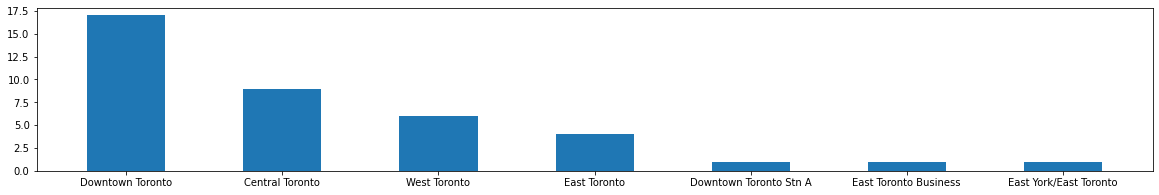

In [301]:
#plot number of neighborhoods in each borough
neighborhood_qty = df_toronto_only.groupby('Borough').count()
neighborhood_qty = neighborhood_qty.sort_values(by=['Neighborhood'], ascending=False)
#neighborhood_qty.reset_index()

plt.figure(figsize=(20,3))
plt.bar(neighborhood_qty.reset_index()['Borough'],neighborhood_qty.reset_index()['Neighborhood'], width=0.5)
plt.show()

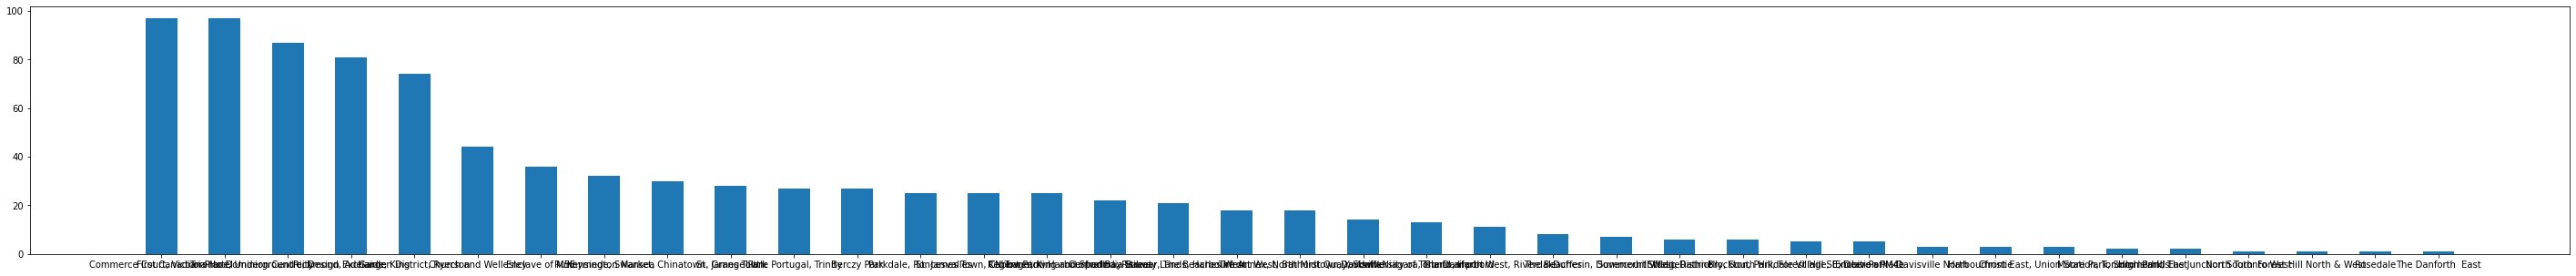

In [307]:
#check how many venues for each neighborhood
#note limitation on Foursquare venues search roughly 23 venues per neighborhood

#toronto_venues.sort_values(by=['Neighborhood'])

venues_qty = toronto_venues.groupby('Neighborhood').count()
venues_qty = venues_qty.sort_values(by=['Venue'], ascending=False)


plt.figure(figsize=(50,5))
plt.bar(venues_qty.reset_index()['Neighborhood'],venues_qty.reset_index()['Venue'], width=0.5)
plt.show()

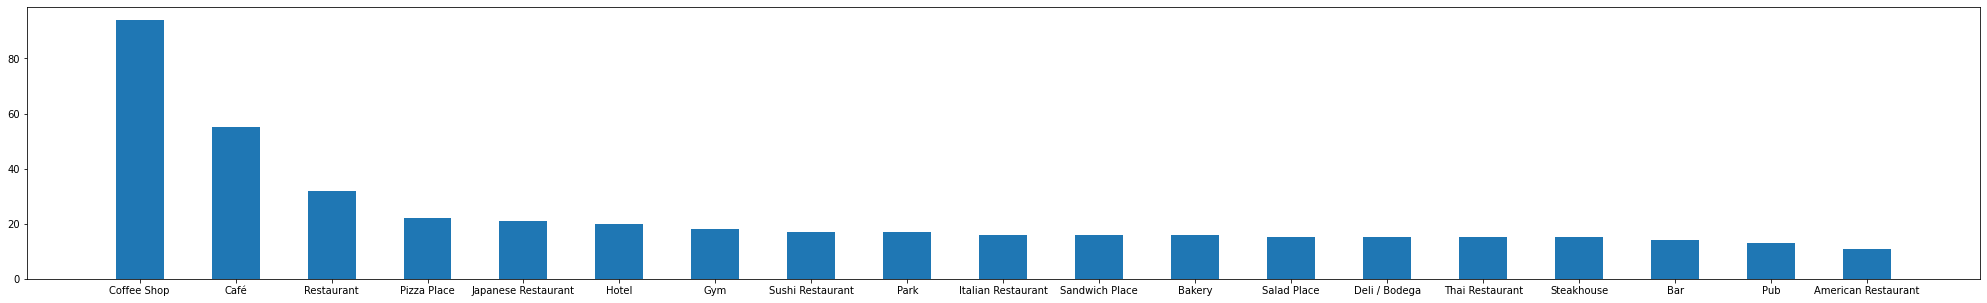

In [309]:
#check how many venues per venue type
#note limitation on Foursquare venues search roughly 23 venues per neighborhood at times



#toronto_venues.sort_values(by=['Neighborhood'])

venues_type = toronto_venues.groupby('Venue Category').count()
venues_type = venues_type.sort_values(by=['Venue'], ascending=False)
#plot only top 20 venue types


plt.figure(figsize=(35,5))
x=venues_type.reset_index()['Venue Category'][0:19]
y=venues_type.reset_index()['Venue'][0:19]
plt.bar(x,y,width=0.5)
plt.show()

### Analyze neighborhood using one hot encoding

In [310]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
 
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
 
toronto_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group rows by neighborhood and taking mean of frequency of occurrence per category

In [348]:
#checking for NAN

#print(toronto_onehot[toronto_onehot['Neighborhood']=="Roselawn"])

#print(toronto_onehot[toronto_onehot['Neighborhood']=="Dufferin, Dovercourt Village"])

print(toronto_venues[toronto_venues["Neighborhood"]=="Roselawn"])

Empty DataFrame
Columns: [Neighborhood, Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, Venue Category]
Index: []


In [333]:
toronto_grouped=toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.shape

(37, 181)

In [335]:
#print each neighbor hood with top 5 most common venues

num_top_venues = 5
for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0    Cocktail Bar  0.11
1  Breakfast Spot  0.07
2             Pub  0.07
3     Coffee Shop  0.07
4        Fountain  0.04


----Brockton, Parkdale Village, Exhibition Place----
         venue  freq
0  Coffee Shop   0.2
1    Pet Store   0.2
2         Café   0.2
3          Bar   0.2
4  Music Venue   0.0


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
               venue  freq
0        Coffee Shop  0.17
1               Park  0.11
2  French Restaurant  0.06
3              Hotel  0.06
4              Diner  0.06


----Central Bay Street----
                       venue  freq
0                Coffee Shop  0.18
1                        Spa  0.09
2                      Hotel  0.05
3                   Tea Room  0.05
4  Middle Eastern Restaurant  0.05


----Christie----
           venue  freq
0           Café  0.67
1  Grocery Store  0.33
2    Yoga Studio  0.00
3         Museum  0.00
4  

### place above into pandas dataframe

In [315]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Create new dataframe and display top 10 venues per neighborhood

In [370]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Cocktail Bar,Breakfast Spot,Pub,Coffee Shop,Fountain,Department Store,Pharmacy,Concert Hall,Comfort Food Restaurant,Museum
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Pet Store,Café,Bar,Music Venue,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark
2,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Park,French Restaurant,Hotel,Diner,Ramen Restaurant,New American Restaurant,Restaurant,Caribbean Restaurant,Café
3,Central Bay Street,Coffee Shop,Spa,Hotel,Tea Room,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Bubble Tea Shop,Steakhouse,Gastropub
4,Christie,Café,Grocery Store,Yoga Studio,Museum,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark


### Create K-Clusters

In [371]:

# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 


array([4, 4, 4, 4, 5, 4, 4, 4, 0, 0, 4, 4, 4, 3, 4, 0, 1, 4, 4, 4, 4, 1,
       4, 4, 4, 1, 4, 4, 4, 4])

In [372]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto_only

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5N,Central Toronto,Roselawn,43.7113,-79.4195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,4.0,Athletics & Sports,Coffee Shop,Liquor Store,Light Rail Station,Supermarket,Museum,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.6899,-79.3853,4.0,Restaurant,Intersection,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark
26,M4S,Central Toronto,Davisville,43.7020,-79.3853,4.0,Sandwich Place,Café,Diner,Movie Theater,Restaurant,Italian Restaurant,Tennis Court,Thai Restaurant,Dessert Shop,Indian Restaurant
24,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.6736,-79.4035,4.0,Café,Coffee Shop,Sandwich Place,Liquor Store,French Restaurant,Cheese Shop,Pub,Middle Eastern Restaurant,Shoe Repair,Burger Joint


In [373]:
# remove rows where cluster = NaN

toronto_merged = toronto_merged.dropna()
#print head
#print(toronto_merged)

#change all in cluster label column from float to indices 
toronto_merged["Cluster Labels"] = toronto_merged["Cluster Labels"].astype(int)

#print head
print(toronto_merged)

   PostalCode                 Borough  \
31        M4V         Central Toronto   
29        M4T         Central Toronto   
26        M4S         Central Toronto   
24        M5R         Central Toronto   
23        M4R         Central Toronto   
21        M5P         Central Toronto   
20        M4P         Central Toronto   
36        M5X        Downtown Toronto   
35        M4X        Downtown Toronto   
33        M4W        Downtown Toronto   
32        M5V        Downtown Toronto   
30        M5T        Downtown Toronto   
27        M5S        Downtown Toronto   
37        M4Y        Downtown Toronto   
0         M5A        Downtown Toronto   
1         M5B        Downtown Toronto   
13        M5K        Downtown Toronto   
2         M5C        Downtown Toronto   
10        M5J        Downtown Toronto   
4         M5E        Downtown Toronto   
16        M5L        Downtown Toronto   
5         M5G        Downtown Toronto   
7         M5H        Downtown Toronto   
6         M6G   

In [375]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
i=0
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, postalcode in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'], toronto_merged['PostalCode']):
    label = folium.Popup(str(poi) + ' \r Cluster ' + str(cluster) + '\r' + str(postalcode), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    i = i+1
       
map_clusters

## Examine Clusters
below cells are the composition of each cluster
* cluster 0, 3 neighborhoods in central, downtown and west toronto. Similarity is that Parks are a number of parks nearby these neighborhoods
* cluster 1 , 3 neighborhoods in this cluster. Similarity is that Parks are the most common venues nearby followed by yoga studio and movie theater. 
* cluster 2 and 3, only 1 neighborhood in these clusters. almost similar breakdown of venues
* cluster 4 has the most neighborhoods. mainly clustered in downtown Toronto, but also in other Boroughs. Main similarity is the bigger emphasis of cafes and coffee shops in these neighborhoods. the variety of popular restaurants are also different than the other clusters. The other clusters are heavily focused on mexican, middle eastern restaurants.

In [378]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0 ,toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Central Toronto,0,Gym / Fitness Center,Park,Breakfast Spot,Yoga Studio,Movie Theater,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
10,Downtown Toronto,0,Music Venue,Park,Athletics & Sports,Movie Theater,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant
8,West Toronto,0,Park,Bus Line,Smoke Shop,Gym,Café,Brazilian Restaurant,Moroccan Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant


In [379]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1 ,toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,1,Park,Yoga Studio,Movie Theater,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark
33,Downtown Toronto,1,Park,Yoga Studio,Movie Theater,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark
22,West Toronto,1,Park,Yoga Studio,Movie Theater,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark


In [380]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2 ,toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East York/East Toronto,2,Convenience Store,Martial Arts School,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater


In [381]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3 ,toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,3,Accessories Store,Movie Theater,Martial Arts School,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark


In [382]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4 ,toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Central Toronto,4,Athletics & Sports,Coffee Shop,Liquor Store,Light Rail Station,Supermarket,Museum,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant
29,Central Toronto,4,Restaurant,Intersection,Museum,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark
26,Central Toronto,4,Sandwich Place,Café,Diner,Movie Theater,Restaurant,Italian Restaurant,Tennis Court,Thai Restaurant,Dessert Shop,Indian Restaurant
24,Central Toronto,4,Café,Coffee Shop,Sandwich Place,Liquor Store,French Restaurant,Cheese Shop,Pub,Middle Eastern Restaurant,Shoe Repair,Burger Joint
36,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Deli / Bodega,Salad Place,Seafood Restaurant,Gym,Asian Restaurant,Japanese Restaurant,Hotel
35,Downtown Toronto,4,Coffee Shop,Café,Pizza Place,Butcher,Restaurant,Liquor Store,Sandwich Place,Sushi Restaurant,Chinese Restaurant,General Entertainment
32,Downtown Toronto,4,Coffee Shop,Park,French Restaurant,Hotel,Diner,Ramen Restaurant,New American Restaurant,Restaurant,Caribbean Restaurant,Café
30,Downtown Toronto,4,Café,Vietnamese Restaurant,Dumpling Restaurant,Caribbean Restaurant,Wine Bar,Coffee Shop,Mexican Restaurant,Cheese Shop,Gaming Cafe,Cocktail Bar
27,Downtown Toronto,4,Café,Yoga Studio,College Arts Building,Dessert Shop,Theater,Italian Restaurant,Bank,Sandwich Place,Bookstore,College Gym
37,Downtown Toronto,4,Gay Bar,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Diner,Sculpture Garden,Salon / Barbershop,Sake Bar,Restaurant,Ramen Restaurant
